In [4]:
cd drive/MyDrive/Colab\ Notebooks/cells

/content/drive/MyDrive/Colab Notebooks/cells


In [185]:
import torch
from torch.utils.data import Dataset, DataLoader
from scipy.io import mmread


class RNA(Dataset):
    def __init__(self, data_file):
        # load the scRNA-seq data from the specified file
        self.data = torch.from_numpy(
            mmread(data_file).astype("float32").transpose().todense())
        print(self.data.shape)
        
    def __len__(self):
        # return the number of examples in the dataset
        return len(self.data)
    
    def __getitem__(self, index):
        # return the preprocessed data for the specified example
        library = self.data[index].sum(dim=-1)
        example = self.data[index]
        return example, library

        

# datasets: hcl, celegan, uc_epi, zfish_ep50_5226
# train_dataset = RNA("cells/data/hcl.mtx")
# train_dataset = RNA("data/zfish_ep50_5226.mtx")
train_dataset = RNA("data/celegan.mtx")
train_loader = DataLoader(train_dataset, batch_size=2**12, shuffle=True) # 2**15


torch.Size([86024, 2766])


In [179]:
test.sum(dim=-1).shape

torch.Size([200])

In [190]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim


class Encoder(nn.Module):
    def __init__(self, d, latent_dim):
        super(Encoder, self).__init__()
        self.fc0 = nn.Linear(in_features=d, out_features=d//2)
        self.fc1 = nn.Linear(in_features=d//2, out_features=d//4)
        self.fc2 = nn.Linear(in_features=d//4, out_features=d//8)
        self.fc3_mean = nn.Linear(in_features=d//8, out_features=latent_dim)
        self.fc3_var  = nn.Linear(in_features=d//8, out_features=latent_dim)

    def forward(self, x):
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mu = self.fc3_mean(x)
        logvar = self.fc3_var(x)
        return mu, logvar
    
class Decoder(nn.Module):
    def __init__(self, d, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=latent_dim, out_features=d//8)
        self.fc2 = nn.Linear(in_features=d//8, out_features=d//4)
        self.fc3 = nn.Linear(in_features=d//4, out_features=d//2)
        self.fc4 = nn.Linear(in_features=d//2, out_features=d)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


class VAE(nn.Module):
    def __init__(self, d=2766, latent_dim=2, kl_weight=1):
        super(VAE, self).__init__()
        self.encoder = Encoder(d, latent_dim)
        self.decoder = Decoder(d, latent_dim)
        self.kl_weight = kl_weight

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x, library=None):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)

        if library is not None:
            recon = F.softmax(recon, dim=-1)
            recon = recon * library.unsqueeze(-1)
            
        return recon, mu, logvar

    def loss(self, x, recon, mu, logvar):
        mse = F.mse_loss(recon, x)
        kld = torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0)
        return mse, kld


dev = "cpu"    
model = VAE(d=next(iter(train_loader))[0].shape[-1], latent_dim=2).to(dev)
model.train()
opt = optim.Adam(model.parameters())
model

VAE(
  (encoder): Encoder(
    (fc0): Linear(in_features=2766, out_features=1383, bias=True)
    (fc1): Linear(in_features=1383, out_features=691, bias=True)
    (fc2): Linear(in_features=691, out_features=345, bias=True)
    (fc3_mean): Linear(in_features=345, out_features=2, bias=True)
    (fc3_var): Linear(in_features=345, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=2, out_features=345, bias=True)
    (fc2): Linear(in_features=345, out_features=691, bias=True)
    (fc3): Linear(in_features=691, out_features=1383, bias=True)
    (fc4): Linear(in_features=1383, out_features=2766, bias=True)
  )
)

In [336]:
# save model
# torch.save(model.state_dict(), "models/VAE.pt")
# model.load_state_dict(torch.load("VAE.pt"))

In [403]:
# From https://github.com/bhavikngala/gaussian_mixture_vae/blob/master/networks/GMVAE.py
class GMVAE(nn.Module):
	'''
	Gaussian Mixture Variational Autoencoder.
	Ref: Deep Unsupervised Clustering with 
	Gaussian Mixture Variational Autoencoders.
	https://arxiv.org/abs/1611.02648
	'''

	def __init__(self, in_size=2766, K=2, x_size=2, w_size=2, hidden_size=500, device='cpu'):
		'''
		params: K; cluster size
				x_size; dimension of latent variable x
				w_size; dimension of latent variable w
				hidden_size; dimension of hidden layer
				device: gpu or cpu
		'''
		super(GMVAE, self).__init__()

		self.in_size = in_size
		self.K = K
		self.x_size = x_size
		self.w_size = w_size
		self.hidden_size = hidden_size
		self.device = device
			
		# output of encoder; [X] -> [x], [w], [z]
		self.fc_mu_x = nn.Linear(self.hidden_size, self.x_size)
		self.fc_logvar_x = nn.Linear(self.hidden_size, self.x_size)
		self.fc_mu_w = nn.Linear(self.hidden_size, self.w_size)
		self.fc_logvar_w = nn.Linear(self.hidden_size, self.w_size)
		self.fc_qz = nn.Linear(self.hidden_size, self.K)

		# prior x for each cluster
		self.fc_mu_px = nn.ModuleList(
			[nn.Linear(self.hidden_size, self.x_size) for i in range(self.K)])
		self.fc_logvar_px = nn.ModuleList(
			[nn.Linear(self.hidden_size, self.x_size) for i in range(self.K)])

		self.encStack = nn.Sequential(
			nn.Linear(self.in_size, self.hidden_size),
			nn.ReLU(),
			nn.Linear(self.hidden_size, self.hidden_size),
			nn.ReLU(),
			nn.Linear(self.hidden_size, self.hidden_size),
			nn.ReLU())
		
		self.decStack = nn.Sequential(
			nn.Linear(self.x_size, self.hidden_size),
			nn.ReLU(),
			nn.Linear(self.hidden_size, self.hidden_size),
			nn.ReLU(),
			nn.Linear(self.hidden_size, self.in_size))

		self.priorGenStack = nn.Sequential(
    		nn.Linear(self.w_size, self.hidden_size),
    		nn.ReLU(),
    		nn.Linear(self.hidden_size, self.hidden_size),
    		nn.ReLU())



	def encoder(self, X):
		'''
		Encoder graph, takes data as input,
		encodes data to latent variables w, x, and z.
		[X] -> [x], [w], [z]
		z is a vector with length equal to K.
		x is a sample from mixture of Gaussians, 
		with the mode corresponding to its class as dominant.
		w is a latent variable from N(0, I) distribution
		'''
		# c1 = self.convStack(X) # optional convolutional 
		h1 = self.encStack(X)
		
		mu_x = self.fc_mu_x(h1)
		logvar_x = self.fc_logvar_x(h1)
		
		mu_w = self.fc_mu_w(h1)
		logvar_w = self.fc_logvar_w(h1)
		
		qz = F.softmax(self.fc_qz(h1))

		return mu_x, logvar_x, mu_w, logvar_w, qz

	def priorGenerator(self, w_sample, batchSize):
		'''
		Generate Gaussians based on latent variable w sample
		[w] -> {[x]}2K
		'''
		h1 = F.tanh(self.priorGenStack(w_sample))

		mu_px = torch.empty(batchSize, self.K, self.x_size,
			device=self.device, requires_grad=False)
		logvar_px = torch.empty(batchSize, self.K, self.x_size,
			device=self.device, requires_grad=False)

		for i in range(self.K):
			mu_px[:, i, :] = self.fc_mu_px[i](h1)
			logvar_px[:, i, :] = self.fc_logvar_px[i](h1)

		return mu_px, logvar_px

	def decoder(self, x_sample):
		'''
		Decoder graph, reconstructs X from latent variable x
		[x] -> [Y]
		'''
		Y = self.decStack(x_sample)
		# optional convolutional stack afterwards
		return Y

	def reparameterize(self, mu, logvar):
		'''
		compute z = mu + std * epsilon
		'''
		if self.training:
			# do this only while training
			# compute the standard deviation from logvar
			std = torch.exp(0.5 * logvar)
			# sample epsilon from a normal distribution with mean 0 and
			# variance 1
			eps = torch.randn_like(std)
			return eps.mul(std).add_(mu)
		else:
			return mu

	def forward(self, X, library=None):
		batchSize = X.size(0)

		mu_x, logvar_x, mu_w, logvar_w, qz = self.encoder(X)
		w_sample = self.reparameterize(mu_w, logvar_w)
		mu_px, logvar_px = self.priorGenerator(
			w_sample, batchSize)

		x_sample = self.reparameterize(mu_x, logvar_x)
		Y = self.decoder(x_sample)
		
		if library is not None:
			Y = F.softmax(Y, dim=-1)
			Y = Y * library.unsqueeze(-1)

		return mu_x, logvar_x, mu_px, logvar_px, qz, Y, mu_w, \
			logvar_w, x_sample


dev = "cpu"    
model = GMVAE(in_size=2766, K=2, x_size=2, w_size=2, hidden_size=500, device=dev)
model.train()
opt = optim.Adam(model.parameters())

In [404]:
import math

def loss_fn(recon_X, X, mu_w, logvar_w, qz,
	mu_x, logvar_x, mu_px, logvar_px, x_sample, x_size, K):
	N = X.size(0) # batch size

	# 1. Reconstruction Cost = -E[log(P(y|x))]
	# unpack Y into mu_Y and logvar_Y
	# mu_recon_X, logvar_recon_X = recon_X

	# use gaussian criteria
	# negative LL, so sign is flipped
	# log(sigma) + 0.5*2*pi + 0.5*(x-mu)^2/sigma^2
	# recon_loss = 0.5 * torch.sum(logvar_recon_X + math.log(2*math.pi) \
	# 		+ (X - mu_recon_X).pow(2)/logvar_recon_X.exp())
	recon_loss = F.mse_loss(recon_X, X)

	# 2. KL( q(w) || p(w) )
	KLD_W = -0.5 * torch.sum(1 + logvar_w - mu_w.pow(2) - logvar_w.exp())

	# 3. KL( q(z) || p(z) )
	KLD_Z = torch.sum(qz * torch.log(K * qz + 1e-10))

	# 4. E_z_w[KL(q(x)|| p(x|z,w))]
	# KL  = 1/2(  logvar2 - logvar1 + (var1 + (m1-m2)^2)/var2  - 1 )
	mu_x = mu_x.unsqueeze(-1)
	mu_x = mu_x.expand(-1, x_size, K)

	logvar_x = logvar_x.unsqueeze(-1)
	logvar_x = logvar_x.expand(-1, x_size, K)

	# shape (-1, x_size, K)
	KLD_QX_PX = 0.5 * (((logvar_px - logvar_x) + \
		((logvar_x.exp() + (mu_x - mu_px).pow(2))/logvar_px.exp())) \
		- 1)

	# transpose to change dim to (-1, x_size, K)
	# KLD_QX_PX = KLD_QX_PX.transpose(1,2)
	qz = qz.unsqueeze(-1)
	qz = qz.expand(-1, K, 1)

	E_KLD_QX_PX = torch.sum(torch.bmm(KLD_QX_PX, qz))

	# 5. Entropy criterion
	
	# CV = H(Z|X, W) = E_q(x,w) [ E_p(z|x,w)[ - log P(z|x,w)] ]
	# compute likelihood
	
	x_sample = x_sample.unsqueeze(-1)
	x_sample =  x_sample.expand(-1, x_size, K)

	temp = 0.5 * x_size * math.log(2 * math.pi)
	# log likelihood
	llh = -0.5 * torch.sum(((x_sample - mu_px).pow(2))/logvar_px.exp(), dim=1) \
			- 0.5 * torch.sum(logvar_px, dim=1) - temp

	lh = F.softmax(llh, dim=1)

	# entropy
	CV = torch.sum(torch.mul(torch.log(lh+1e-10), lh))
	
	loss = recon_loss + KLD_W + KLD_Z + E_KLD_QX_PX
	return loss, recon_loss, KLD_W, KLD_Z, E_KLD_QX_PX, CV


In [405]:
kl_weight = 0.5
num_epochs =25

# for each epoch
for epoch in range(num_epochs):
    # epoch losses
    mse_e, kld_e = 0, 0
    i = 0
  # for each data batch
    for x, lib in train_loader:
        x = x.to(dev)
        lib = lib.to(dev)

        opt.zero_grad()
        
        # vae
        # recon, mu, logvar = model(x, library=lib)
        # mse, kld = model.loss(x, recon, mu, logvar)
        # loss = mse + kl_weight * kld
        
        # gmvae
        mu_x, logvar_x, mu_px, logvar_px, qz, recon, mu_w, \
          logvar_w, x_sample = model(x, library=lib)
        
        loss, recon_loss, KLD_W, \
          KLD_Z, E_KLD_QX_PX, CV = loss_fn(recon, x, mu_w, logvar_w, qz,	mu_x, logvar_x, mu_px, logvar_px, x_sample, model.x_size, model.K)

        loss.backward()
        opt.step()
        
        mse_e += mse
        kld_e += kld
        i += 1

    print("Epoch: {}, MSE: {}, KLD: {}".format(epoch, 
                                               mse_e/i, 
                                               kld_e/i))





/tmp/ipykernel_68319/2985712173.py:82: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  qz = F.softmax(self.fc_qz(h1))


Epoch: 0, MSE: 3.8216352462768555, KLD: 0.9419548511505127
Epoch: 1, MSE: 3.8216352462768555, KLD: 0.9419548511505127
Epoch: 2, MSE: 3.8216352462768555, KLD: 0.9419548511505127
Epoch: 3, MSE: 3.8216352462768555, KLD: 0.9419548511505127
Epoch: 4, MSE: 3.8216352462768555, KLD: 0.9419548511505127
Epoch: 5, MSE: 3.8216352462768555, KLD: 0.9419548511505127
Epoch: 6, MSE: 3.8216352462768555, KLD: 0.9419548511505127
Epoch: 7, MSE: 3.8216352462768555, KLD: 0.9419548511505127
Epoch: 8, MSE: 3.8216352462768555, KLD: 0.9419548511505127
Epoch: 9, MSE: 3.8216352462768555, KLD: 0.9419548511505127
Epoch: 10, MSE: 3.8216352462768555, KLD: 0.9419548511505127
Epoch: 11, MSE: 3.8216352462768555, KLD: 0.9419548511505127
Epoch: 12, MSE: 3.8216352462768555, KLD: 0.9419548511505127
Epoch: 13, MSE: 3.8216352462768555, KLD: 0.9419548511505127
Epoch: 14, MSE: 3.8216352462768555, KLD: 0.9419548511505127
Epoch: 15, MSE: 3.8216352462768555, KLD: 0.9419548511505127
Epoch: 16, MSE: 3.8216352462768555, KLD: 0.9419548

In [205]:
# z = model.reparameterize(*model.encoder(test))

# for i in range(z.shape[1]):
#     model.decoder.zero_grad()
#     leaf = z[0].detach().requires_grad_()
#     out = model.decoder(z[0])[i]
#     out.retain_grad()
#     out.backward(retain_graph=True)
#     gene_gradients.append(out.grad.clone().detach())


# G = torch.stack(gene_gradients)

# G

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1.], device='cuda:0')

In [161]:
# Updated 14/02/2023: 

from functorch import jacfwd, vmap

def jac(f, z):
    # composed with vmap for batched Jacobians
    return vmap(jacfwd(f))(z)

# gene "correlation" matrix C
def C_matrix(f, z, normalize=False):
    '''
    f:      model.decode: (b, m) -> (b, n) 
    z:      torch.tensor whose size = (b, m) (keep b low for memory)
    out:    torch.tensor whose size = (b, n, n)
    '''
    J = jac(f, z)

    # J @ J.T on batch 
    if normalize:
        return torch.bmm(J, J.transpose(1,2)) / J.norm(p=2, dim=2).unsqueeze(-1)
    else:
        return torch.bmm(J, J.transpose(1,2))



def jac_robust(f, z):
    # alternative jac if experiencing crashes 
    batch_size, z_dim = z.size()
    v = torch.eye(z_dim).unsqueeze(0).repeat(batch_size, 1, 1).view(-1, z_dim).to(z)
    z = z.repeat(1, z_dim).view(-1, z_dim)
    return torch.autograd.functional.jvp(f, z, v=v)[1].view(batch_size, z_dim, -1).permute(0, 2, 1)


# jacrev: 1.45s
# jacfwd: 80-90ms 
# jvp:    85-92ms 
    # /J.norm(p=2, dim=2).unsqueeze(-1)
    # out = torch.einsum('nij,nik->njk', J, J) # J.T @ J, riem. metric 

In [6]:
# test = next(iter(DataLoader(train_dataset, batch_size=train_dataset.__len__(), shuffle=False)))
test = next(iter(DataLoader(train_dataset, batch_size=200, shuffle=False)))


In [332]:
z = model.reparameterize(*model.encoder(test))

z[0]

tensor([0.9048, 0.7780], grad_fn=<SelectBackward0>)

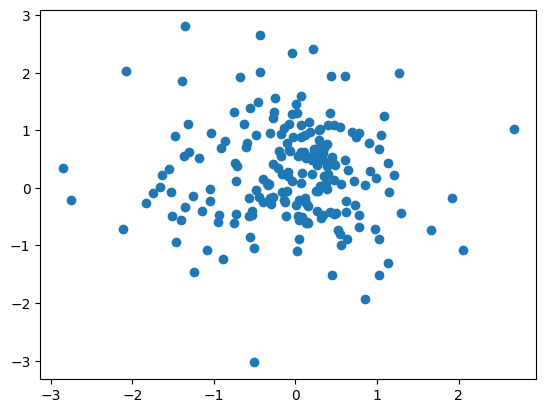

In [333]:
from matplotlib import pyplot as plt

zt = z.detach().numpy()


plt.scatter(zt[:,0], zt[:,1])

In [52]:
z = model.reparameterize(*model.encoder(test))

lim = 5
# j = JofD(model.decoder, z)[0]
# m1 = (j@ j.T) / j.norm(p=2, dim=1).unsqueeze(-1)


In [162]:
%%time
m2 = C_matrix(model.decoder, z[:lim])
m2.shape

(5, 2766, 2766)

torch.Size([5, 2766, 1])
CPU times: user 498 ms, sys: 366 ms, total: 863 ms
Wall time: 185 ms


(5, 2766, 2766)

In [100]:
z[0], z[1]

(tensor([0.9203, 0.4122], grad_fn=<SelectBackward0>),
 tensor([-0.3922,  0.7697], grad_fn=<SelectBackward0>))

## Trajectories

In [12]:
def get_Riemannian_metric(f, z, create_graph=False): #J.T @ J instead! 
    J = create_jac(f, z, create_graph=create_graph)
    out = torch.einsum('nij,nik->njk', J, J)
    return out


In [13]:
def compute_geodesic(z1, z2, pretrained_model, get_Riemannian_metric, num_discretization=100):
    '''
    z1 : torch.tensor whose size = (1, 2)
    z1 : torch.tensor whose size = (1, 2)
    out: torch.tensor whose size = (num_discretization, 2)
    '''
    from scipy.optimize import minimize
    class GeodesicFittingTool():
        def __init__(self, z1, z2, z_init, pretrained_model, get_Riemannian_metric, num_discretization, method, device=f"cuda:{0}"):
            self.z1 = z1
            self.z2 = z2
            self.pretrained_model = pretrained_model
            self.get_Riemannian_metric = get_Riemannian_metric
            self.num_discretization = num_discretization
            self.delta_t = 1/(num_discretization-1)
            self.device = device
            self.method = method
            self.z_init_input = z_init
            self.initialize()
            
        def initialize(self):
            self.z_init= self.z1.squeeze(0)
            self.z_final= self.z2.squeeze(0)
            dim = self.z_final.size(0)
            self.init_z = self.z_init_input.detach().cpu().numpy()
            self.z_shape = self.init_z.shape
            self.init_z_vec = self.init_z.flatten()

        def geodesic_loss(self, z): 
            z_torch = torch.tensor(z.reshape(self.z_shape), dtype=torch.float32).to(self.device)
            z_extended = torch.cat([self.z_init.unsqueeze(0), z_torch, self.z_final.unsqueeze(0)], dim=0)
            G_ = self.get_Riemannian_metric(self.pretrained_model.decode, z_extended[:-1])
            delta_z = (z_extended[1:, :]-z_extended[:-1, :])/(self.delta_t)
            loss = torch.einsum('ni, nij, nj -> ', delta_z, G_, delta_z) * self.delta_t
            return loss.item()
        
        def jac(self, z):
            z_torch = torch.tensor(z.reshape(self.z_shape), dtype=torch.float32).to(self.device)
            z_torch.requires_grad = True
            z_extended = torch.cat([self.z_init.unsqueeze(0), z_torch, self.z_final.unsqueeze(0)], dim=0)
            G_ = self.get_Riemannian_metric(self.pretrained_model.decode, z_extended[:-1], create_graph=True)
            delta_z = (z_extended[1:, :]-z_extended[:-1, :])/(self.delta_t)
            loss = torch.einsum('ni, nij, nj -> ', delta_z, G_, delta_z) * self.delta_t
            loss.backward()
            z_grad = z_torch.grad
            return z_grad.detach().cpu().numpy().flatten()

        def callback(self, z):
            self.Nfeval += 1
            return print('{} th loss : {}'.format(self.Nfeval, self.geodesic_loss(z)))
            
        def BFGS_optimizer(self, callback=False, maxiter=1000):
            self.Nfeval = 0
            z0 = self.init_z_vec
            if callback == True:
                call = self.callback
            else:
                call = None
            res = minimize(
                self.geodesic_loss, 
                z0, 
                callback=call, 
                method=self.method,
                jac = self.jac,
                options = {
                    'gtol': 1e-10, 
                    'eps': 1.4901161193847656e-08, 
                    'maxiter': maxiter, 
                    'disp': True, 
                    'return_all': False, 
                    'finite_diff_rel_step': None}
                )
            self.res = res

    z12_linear_curve = torch.cat([z1.to(device) + (z2.to(device) - z1.to(device)) * t/(num_discretization-1) for t in range(num_discretization)], dim=0)
    
    tool = GeodesicFittingTool(z1, z2, z12_linear_curve[1:-1], pretrained_model, get_Riemannian_metric, num_discretization, 'BFGS', device=device)
    tool.BFGS_optimizer()
    z_torch = torch.tensor(tool.res['x'].reshape(tool.z_shape), dtype=torch.float32).to(device)
    out = torch.cat([tool.z_init.unsqueeze(0), z_torch, tool.z_final.unsqueeze(0)], dim=0)
    return out


In [ ]:
z1 = torch.tensor([[-1, 1]], dtype=torch.float32) 
z2 = torch.tensor([[0.6, -1.2]], dtype=torch.float32) 

num_discretization = 100
z12_geodesic_curve = compute_geodesic(
    z1.to(device), 
    z2.to(device), 
    pretrained_model, 
    get_Riemannian_metric, 
    num_discretization=num_discretization
)
assert z12_geodesic_curve.size() == torch.Size([num_discretization, 2])


In [ ]:
L12 = compute_length_of_curve(
    z12_geodesic_curve, pretrained_model, get_Riemannian_metric)
L12


In [ ]:
z12_linear_curve = torch.cat([z1.to(device) + (z2.to(device) - z1.to(device)) * t/(num_discretization-1) for t in range(num_discretization)], dim=0)

latent_embeddings = pretrained_model.encode(
    train_ds.data.to(device)
    ).detach().cpu().numpy()

z_scale = np.minimum(
    np.max(latent_embeddings, axis=0), 
    np.min(latent_embeddings, axis=0)
)
labels = torch.unique(train_ds.targets)

f = plt.figure(figsize=(7, 7))
plt.title('Latent space embeddings')
for label in labels:
    classwise_le = latent_embeddings[train_ds.targets == label]
    plt.scatter(
        classwise_le[:200, 0], 
        classwise_le[:200, 1], 
        label=label.item(), s=5)

plt.scatter(z1[0, 0], z1[0, 1], c='tab:red', marker='s')
plt.scatter(z2[0, 0], z2[0, 1], c='tab:green', marker='s')

plt.scatter(z12_linear_curve[:, 0].detach().cpu(), z12_linear_curve[:, 1].detach().cpu(), s=10, c='tab:gray')
plt.scatter(z12_geodesic_curve[:, 0].detach().cpu(), z12_geodesic_curve[:, 1].detach().cpu(), s=10, c='tab:pink')

plt.xlim(-3, 3)
plt.ylim(-3, 3)

plt.legend()
plt.show()
